This is a sample file that imports clean data as a Pickle file, removes unnecessary columns to: 1) Generate a Correlation heatmap; 2) Train the model after normalization with Ridge (Lasso, ElasticNet etc were also tested with the same code); 3) Tests the model with the trained model on train and test data; 4) Steps 2&3 are repeated with different degrees of polynomial complexity for features of interest.

In [1]:
import pickle as pkl
import scipy.stats as stats
from itertools import product
import numpy as np
import seaborn as sns
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import KFold
import warnings
warnings.filterwarnings('ignore')

/home/chintan/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/home/chintan/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
with open('Data_cleaned.pkl', 'rb') as picklefile: 
    df1 = pkl.load(picklefile)

In [3]:
import patsy
X1=patsy.dmatrix('Fuel',data=df1,return_type='dataframe')
X2=patsy.dmatrix('Transmission',data=df1,return_type='dataframe')
X3=patsy.dmatrix('Title',data=df1,return_type='dataframe')

In [6]:
def correlation_matrix(df):
    from matplotlib import pyplot as plt
    from matplotlib import cm as cm

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
    cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap)
    ax1.grid(True)
    plt.title('Correlation Matrix Heatmap')
    labels=['Odometer', 'Year', 'Fuel Type', 'Transmission','Rebuilt Title', 'Salvage Title', 'Price']
    ax1.set_xticklabels(labels,fontsize=6)
    ax1.set_yticklabels(labels,fontsize=6)
    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    fig.colorbar(cax, ticks=[.75,.8,.85,.90,.95,1])
    plt.show()

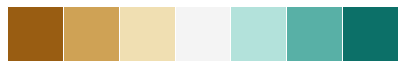

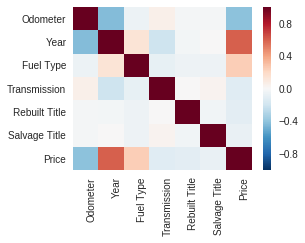

In [14]:
y = df1['Price']
import pandas as pd
df2=pd.merge(df1, X1,left_index=True, right_index=True)
df3=pd.merge(df2, X2,left_index=True, right_index=True)
x=pd.merge(df3, X3,left_index=True, right_index=True)
del x['Transmission']
del x['Title']
del x['Make']
del x['Model']
del x['Fuel']
del x['Price']
del x['Intercept_y']
del x['Intercept']
del x['Intercept_x']
x['Price']=y
# x.sample(10)
x.columns=['Odometer', 'Year', 'Fuel Type', 'Transmission','Rebuilt Title', 'Salvage Title', 'Price']
corr = x.corr()
# plot the heatmap
# cmap = sns.cubehelix_palette(start=1.6, light=0.8, as_cmap=True, reverse=True)
# cmap=sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=.95, as_cmap=True, reverse=True)
cmap=sns.palplot(sns.color_palette("BrBG", 7))


fig, ax = plt.subplots(figsize=(4,3))         # Sample figsize in inches
# sns.heatmap(df1.iloc[:, 1:6:], annot=True, linewidths=.5, ax=ax)
ax.set_xticklabels(labels=corr.columns,rotation=90, ha='left')
sns.heatmap(corr, annot=False, fmt="g", cmap=cmap,ax=ax)
# sns.heatmap(corr,xticklabels=corr.columns, yticklabels=corr.columns)
# correlation_matrix(x)
plt.savefig('heatmap_corr.png', format='png', dpi=1000,bbox_inches='tight')

In [68]:
# 'for' loop over the entire dataset with price as the dependant variable (versus quantitative and categorical variables)
r2_tr_by_degree=[]
r2_te_by_degree=[]
sse_tr_by_degree=[]
sse_te_by_degree=[]
degrees=[]
for deg in range(1,15):
    degrees.append(deg)
    x_poly_features=df1[['Odometer','Year']]
    p = PolynomialFeatures(deg)
    XP = p.fit_transform(x_poly_features)
    new_df=pd.DataFrame(XP)
    s = StandardScaler()
    XS = s.fit_transform(new_df)
    new_df=pd.DataFrame(XS)
    indexes=list(y.index)
    new_df.set_index([indexes],inplace=True)
    column_names=[]
    for x in range(len(new_df.columns)):
        column_names.append('X'+str(x))
    new_df.columns=column_names
    new_df['Price']=y
    new_df=pd.merge(new_df, X1,left_index=True, right_index=True)
    new_df=pd.merge(new_df, X2,left_index=True, right_index=True)
    new_df=pd.merge(new_df, X3,left_index=True, right_index=True)
    new_df.rename(columns={'Price':'P','Intercept_x':'IX','Fuel[T.other]':'Fuel_other','Intercept_y':'IY','Transmission[T.manual]':'Trans_manual','Intercept':'IZ','Title[T.rebuilt]':'Title_rebuilt','Title[T.salvage or missing]':'Title_sal_or_mis'},inplace=True)
    lr_str='P ~ X0'
    y_skl=new_df['P']
    x_skl=new_df
    del x_skl['P']
    x_skl_train, x_skl_test, y_skl_train, y_skl_test = train_test_split(x_skl, y_skl, test_size=0.2,random_state=22)
    # alphas = [1e-14, 1e-8, 1e-2, 100]
    alpha=1e-8
#     sse_tr_Ridge = []
#     sse_te_Ridge = []
#     r2_tr_Ridge = []
#     r2_te_Ridge = []
    # for alpha in alphas:
#     lr=LinearRegression()
    lr=Ridge(alpha=alpha)
#     lr=Lasso(alpha=alpha)
    lr.fit(x_skl_train, y_skl_train)
    lr.score(x_skl_test,y_skl_test)
    r2_tr_by_degree.append(lr.score(x_skl_train,y_skl_train))
    r2_te_by_degree.append(lr.score(x_skl_test,y_skl_test))
    sse_tr_by_degree.append(mean_squared_error(y_skl_train, lr.predict(x_skl_train)))
    sse_te_by_degree.append(mean_squared_error(y_skl_test, lr.predict(x_skl_test)))
    
# sse_tr_Ridge.append(mean_squared_error(y_skl_train, lr.predict(x_skl_train)))
# sse_te_Ridge.append(mean_squared_error(y_skl_test, lr.predict(x_skl_test)))
# r2_tr_Ridge.append(lr.score(x_skl_train,y_skl_train))
# r2_te_Ridge.append(lr.score(x_skl_test,y_skl_test))

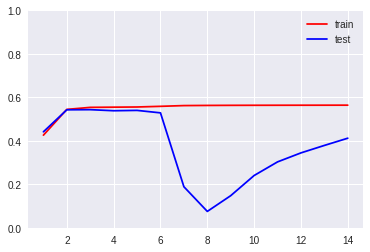

In [69]:
plt.plot(degrees,r2_tr_by_degree,label='train',c='r')
plt.plot(degrees,r2_te_by_degree,label='test',c='b')
plt.ylim(0,1)
plt.legend()

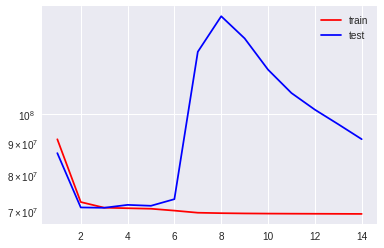

In [70]:
plt.semilogy(degrees,sse_tr_by_degree,label='train',c='r')
plt.semilogy(degrees,sse_te_by_degree,label='test',c='b')
plt.legend()

In [71]:
# plt.semilogx(alphas,sse_tr_Ridge,label='train',c='r')
# plt.semilogx(alphas,sse_te_Ridge,label='test',c='b')
# plt.legend()

In [72]:
# plt.semilogx(alphas,r2_tr_Ridge,label='train',c='r')
# plt.semilogx(alphas,r2_te_Ridge,label='test',c='b')
# plt.ylim(0,1)
# plt.legend()